# Imports

In [1]:
 config = {
    'gdt': {
        'depth': 10,
        
        'learning_rate_index': 0.05,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.005,
        
        'split_index_activation': 'entmax',
                
        'optimizer': 'SWA', #adam with stochastic weight averaging
        
        'initializer': 'GlorotUniform', 
        
        'dropout': 0,
        
        'prunePostHoc': True,
        'prune_threshold': 1,
        
        'batch_size': 128,#512,
        'epochs': 10_000,
        
        'loss': 'crossentropy', #binary_focal_crossentropy, binary_crossentropy
        
        'focalLossGamma': 3,
        
        'polyLoss': False,
        'polyLossEpsilon': 2,
        
        'restarts': 3,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 200,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 0.0,
    },
    
    'preprocessing': {
        'balance_threshold': 0.25,#.25, #if minclass fraction less than threshold/num_classes-1 | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'quantile', #'min-max'
        'quantile_noise': 1e-3,
    },

    'computation': {
        'random_seed': 42,
        'trials': 10,
        
        'use_best_hpo_result': True,
        'hpo_path': '_DEFAULT',
        
        'force_depth': False,
        'force_dropout': False,
        'force_restart': True,   
        
        'use_gpu': True,
        'gpu_numbers': '0',#'1',
        'n_jobs': 10,
        'verbosity': 0,
        
        'hpo': None,
        'search_iterations': 300,
        'cv_num': 3,     
        
        'metrics_class': ['f1', 'roc_auc', 'accuracy', 'total_nodes','internal_node_num', 'leaf_node_num'],      
        'eval_metric_class': ['f1', 'roc_auc', 'accuracy', 'total_nodes', 'internal_node_num', 'leaf_node_num'], #f1 accuracy
    },
    
    'benchmarks': {
        'DNDT': True,
        'GeneticTree': True,
        'DL85': True,
        
        'sklearn': True,
        
        'NeuralNetwork': False,
    }
}

In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K

import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT import *
from utilities.DNDT import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])
tf.keras.utils.set_random_seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results" + config['computation']['hpo_path'] + "/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results' + config['computation']['hpo_path'] + '/depth' + str(config['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")

2023-05-03--12-37-34724424


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


# Evaluation

In [4]:
identifier_list_classification_multi = [
                        'MULT:Iris',# 150 4 3
                        'MULT:Balance Scale',# 625 4 3
                        'MULT:Car',# 1728 6 4
                        'MULT:Glass',# 214 9 6 
                        'MULT:Contraceptive',# 1473 9 3 
                        'MULT:Solar Flare',# 1389 10 8
                        'MULT:Wine',# 178 12 3
                        'MULT:Zoo',#101 16 7   ###TD
                        'MULT:Lymphography',# 148 18 4 ###TD
                        'MULT:Segment',# 2310 19 7
                        'MULT:Dermatology',# 366 34 6
                        'MULT:Landsat',# 6435 36 6
                        'MULT:Annealing',# 798 38 5
                        'MULT:Splice',# 3190 60 3
                  ]       

In [5]:
identifier_list_classification_binary = [
                        'BIN:Blood Transfusion',# 748 4
                        'BIN:Banknote Authentication',# 1372 4
                        'BIN:Titanic',# 891 7 
                        'BIN:Raisins',#900 7
                        'BIN:Rice',#3810 7
                        'BIN:Echocardiogram',#132 8 ###TD
                        'BIN:Wisconsin Diagnostic Breast Cancer',# 569 10
                        'BIN:Loan House',# 614 11
                        'BIN:Heart Failure',# 299 12
                        'BIN:Heart Disease',# 303 13
                        'BIN:Adult',# 32561 14
                        'BIN:Bank Marketing',# 45211 14
                        'BIN:Congressional Voting',# 435, 16 ###TD
                        'BIN:Absenteeism',# 740 18
                        'BIN:Hepatitis',#155 19 ###TD
                        'BIN:German',# 1000 20
                        'BIN:Mushroom',#8124 22
                        'BIN:Credit Card',# 30000 23
                        'BIN:Horse Colic',#368 27
                        'BIN:Thyroid',#9172 29 ###TD
                        'BIN:Cervical Cancer',# 858 15
                        'BIN:Spambase',# 4601 57
                  ]       

In [6]:
dataset_dict, config_training, metrics = prepare_training(identifier = 'BIN:Wisconsin Diagnostic Breast Cancer', config = config)

model_dict = {}

verbosity = 0

model_dict['GDT'] = GDT(number_of_variables = dataset_dict['number_of_variables'],
            number_of_classes = dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            split_index_activation = config_training['gdt']['split_index_activation'],
            dropout = config_training['gdt']['dropout'],

            prunePostHoc = config_training['gdt']['prunePostHoc'],
            prune_threshold = config_training['gdt']['prune_threshold'],

            optimizer = config_training['gdt']['optimizer'],

            loss = config_training['gdt']['loss'],

            focalLossGamma = config_training['gdt']['focalLossGamma'],    

            polyLoss = config_training['gdt']['polyLoss'],    
            polyLossEpsilon = config_training['gdt']['polyLossEpsilon'],    

            initializer = config_training['gdt']['initializer'],     

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)#5      


history = model_dict['GDT'].fit(dataset_dict['X_train'],
          dataset_dict['y_train'],

          batch_size=config_training['gdt']['batch_size'], 
          epochs=config_training['gdt']['epochs'], 

          restarts = 0,#config_training['gdt']['restarts'], 
          #restart_type=config_training['gdt']['restart_type'], 

          early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
          early_stopping_type=config_training['gdt']['early_stopping_type'],

          valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))

X_train_data_extended = pd.concat([dataset_dict['X_train'], dataset_dict['X_valid']])
y_train_data_extended = pd.concat([dataset_dict['y_train'], dataset_dict['y_valid']])      
number_of_classes = len(np.unique(np.concatenate([dataset_dict['y_train'].values, dataset_dict['y_valid'].values, dataset_dict['y_test'].values])))

model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_training['gdt']['depth'], 
                                      random_state=config_training['computation']['random_seed'])

model_dict['sklearn'].fit(enforce_numpy(X_train_data_extended), 
                          enforce_numpy(y_train_data_extended))


model_dict['GeneticTree'] = GeneticTree()
model_dict['GeneticTree'] = model_dict['GeneticTree'].fit(enforce_numpy(X_train_data_extended), 
                                                          enforce_numpy(y_train_data_extended))        

if dataset_dict['X_train'].shape[1] <= 12:
    if config_training['computation']['use_gpu']:
        with tf.device('/device:GPU:0'):     

            model_dict['DNDT'] = DNDT(num_features = dataset_dict['X_train'].shape[1],
                         num_classes = number_of_classes)

            model_dict['DNDT'].fit(dataset_dict['X_train'], 
                      dataset_dict['y_train'],
                      valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']),
                      epochs=1000)       
    else:
        model_dict['DNDT'] = DNDT(num_features = dataset_dict['X_train'].shape[1],
                     num_classes = number_of_classes)

        model_dict['DNDT'].fit(dataset_dict['X_train'], 
                  dataset_dict['y_train'],
                  valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']),
                  epochs=1000)      

transformer_binarize = get_binarize_transformer(dataset_dict['X_train'], dataset_dict['X_valid'], dataset_dict['X_test'])

model_dict['DL85'] = DL85Classifier(max_depth=4)

model_dict['DL85'].fit(transformer_binarize.transform(X_train_data_extended), 
          y_train_data_extended)


scores_dict = calculate_scores(model_dict = model_dict, 
                               dataset_dict = dataset_dict, 
                               transformer_binarize=transformer_binarize,
                               scores_dict = prepare_score_dict(config=config_training), 
                               metrics = metrics)           



restarts:   0%|          | 0/1 [00:00<?, ?it/s]

epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Test f1 GDT (0) 0.9326521924223073
Test roc_auc GDT (0) 0.9151576123407109
Test accuracy GDT (0) 0.9380530973451328
Test total_nodes GDT (0) 11
Test internal_node_num GDT (0) 5
Test leaf_node_num GDT (0) 6
________________________________________________________________________________________________________
Test f1 sklearn (0) 0.9249169435215947
Test roc_auc sklearn (0) 0.9290744466800805
Test accuracy sklearn (0) 0.9292035398230089
Test total_nodes sklearn (0) 57
Test internal_node_num sklearn (0) 28
Test leaf_node_num sklearn (0) 29
________________________________________________________________________________________________________
Test f1 GeneticTree (0) 0.8774301209845641
Test roc_auc GeneticTree (0) 0.8792756539235412
Test accuracy GeneticTree (0) 0.8849557522123894
Test total_nodes GeneticTree (0) 3
Test internal_node_num GeneticTree (0) 1
Test leaf_node_num GeneticTree (0) 2
___________________________________________________________________________________________________

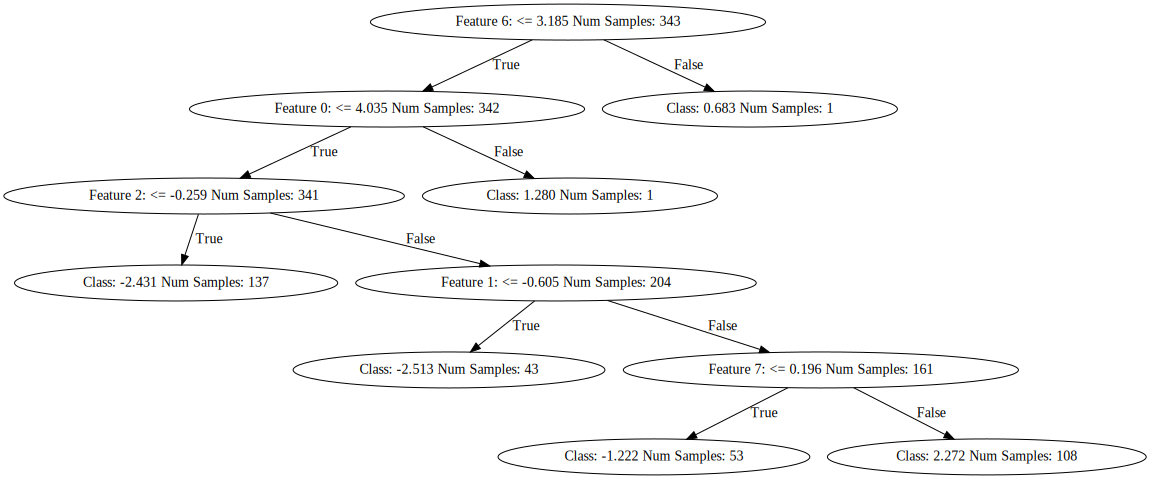

In [7]:
model_dict['GDT'].tree_class.plot_tree()

In [8]:
from numba import cuda 
if config['computation']['use_gpu']:
    device = cuda.get_current_device()
    device.reset()